# Pre-training and Transfer Learning vs Fine tuning

-  Pre training(사전 학습):
  - 데이터셋을 기반으로 충분히 학습을 완료한 모델을 말한다.
- Transfer Learning(전이 학습):
  - pretrained model을 새로운 데이터셋(features, label)로 다시 학습시키는 것을 말한다.
- Fine tuning(미세 조정):  
  - Transfer Learning과는 달리 pretrained model의 일부 layer를 수정하여 새로운 데이터셋(features, label)로 다시 학습시키는 것을 말한다.

# Fine Tuning 전략

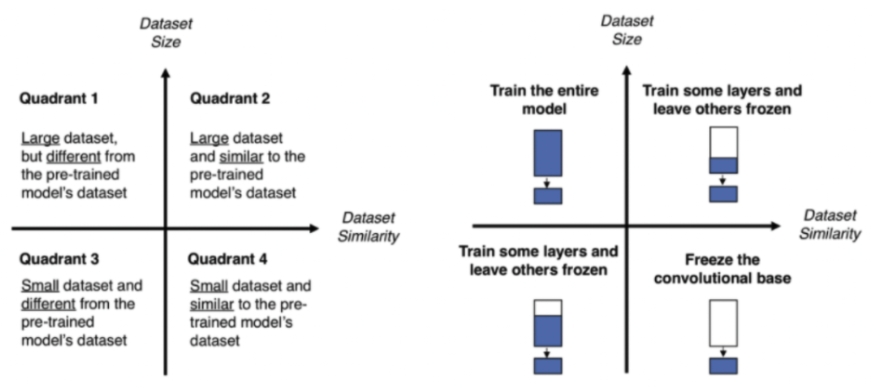

데이터셋의 크기와 이 데이터셋이 Pre-trained model이 기존에 학습한 데이터셋과 얼마나 유사한지에 따라 전략이 달라진다.

1. 우리 데이터셋이 크고, 유사성이 작다.
  - 모델 전체를 학습시키는 것이 낫다.   
  > 데이터셋의 크기가 크기 때문에 충분히 학습이 가능하기 때문. 유사성이 작다고 해서 모델의 구조와 파라미터들은 여전히 재사용 가능하므로, 모델 전체를 학습 시켜주는 편이 낫다.
2.  우리 데이터셋이 크고, 유사성이 크다.
  - Pre-trained Model의 일부분과 Classifier를 학습시킨다.   
  > 사실 최적의 경우이기 때문에 모든 옵션을 선택할 수 있지만, 데이터셋이 유사하기 때문에 전체를 학습시켜도 괜찮지만, 강한 feature가 나타나는 Pre-trained Model의 뒷부분과 Classifier만 새로 학습시키는 것이 최적이다.
3. 우리 데이터셋이 작고, 유사성이 작다.
  - Pre-trained Model의 일부분과 Classifier를 학습시킨다.    
  > 가장 나쁜 상황. 데이터가 적기 때문에 적은 레이어를 Fine tuning하면 별 효과가 없고, 많은 레이어를 Fine tuning했다가는 오히려 오버피팅이 발생할 것이다. 따라서 Pre-trained Model의 어느 정도를 새로 학습시켜야 할지를 적당히 잡아주어야 한다.
4. 우리 데이터셋이 작고, 유사성이 크다.
  - Classifier만 학습시킨다.    
  > 데이터가 적기 때문에 많은 레이어를 Fine tuning할 경우 오버피팅이 발생한다. 따라서 앞부분의 Feature Extraction은 그대로 쓰고, 최종 Classifier의 FC Layer들에 대해서만 Fine tuning을 진행한다.


In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random # 시드 고정을 위해
import os # 시드 고정을 위해

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

# [전이학습 모델](https://heekangpark.github.io/nlp/huggingface-bert)

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00


In [3]:
!pip install -U huggingface_hub

## [User access tokens 생성 방법](https://huggingface.co/docs/hub/security-tokens)

In [4]:
# !huggingface-cli login

In [5]:
# from huggingface_hub import notebook_login

# notebook_login()

## Tokenizer
- Huggingface에서 제공하는 대부분의 transformer 모델들은 텍스트를 바로 입력으로 받을 수 없다.
- 예를 들어 BERT 모델의 경우 문자열로 된 텍스트 그 자체가 아닌, 텍스트를 tokenize한 후 각 token들을 고유한 정수로 바꾼 것이다.
- 즉, token id들의 리스트(sequence of token ids)를 입력으로 받는다. 게다가 attention_mask, token_type_ids와 같은 추가 적인 데이터를 요구한다.

Huggingface에서는 각 모델별로 tokenizer라는 것을 제공한다. tokenizer는 자신과 짝이 맞는 모델이 어떤 형태의 입력을 요구하는지를 알고 있어, tokenizer를 이용하면 텍스트를 전처리, 가공해 모델의 입력값(model input)을 만들 수 있다.

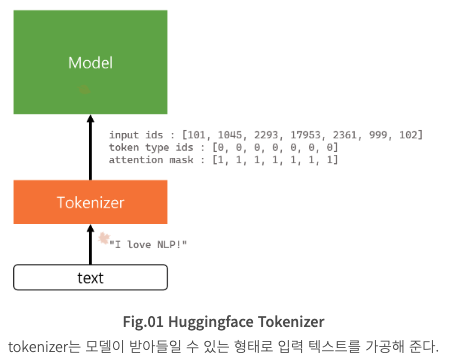

In [6]:
model_name = "bert-base-uncased"

In [7]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer가 반환하는 출력값은 여러 항목들이 들어 있는 python dictionary이고(정확히는 `BatchEncoding` 객체이다.), 각 항목의 값들은 python list이다.  

`bert-base-uncased` tokenizer 출력값에 있는 각 항목의 의미는 다음과 같다.
- `input_ids`:   
token들의 id 리스트(sequence of token id).
- `token_type_ids`:    
각 token이 어떤 문장에 속하는지를 나타내는 리스트. BERT는 한 번에 두 문장(sentence A, sentence B)을 입력으로 받을 수 있는데, `bert-base-uncased` tokenizer는 sentence A에 속하는 token에는 0을, sentence B에 속하는 token에는 1을 부여한다.
- `attention_mask`:    
attention 연산이 수행되어야 할 token과 무시해야 할 token을 구별하는 정보가 담긴 리스트. `bert-base-uncased` tokenizer는 attention 연산이 수행되어야 할, 일반적인 token에는 1을 부여하고, padding과 같이 attention 연산이 수행될 필요가 없는 token들에는 0을 부여한다.

In [8]:
tokens = tokenizer("I love NLP!")
tokens

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokens = tokenizer("I love NLP!")

print(f"tokens.keys : {tokens.keys()}")
print(f"input ids : {tokens['input_ids']}")
print(f"token type ids : {tokens['token_type_ids']}")
print(f"attention mask : {tokens['attention_mask']}")

tokens.keys : dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input ids : [101, 1045, 2293, 17953, 2361, 999, 102]
token type ids : [0, 0, 0, 0, 0, 0, 0]
attention mask : [1, 1, 1, 1, 1, 1, 1]


In [10]:
tokens = tokenizer(["I love NLP!", "I love NLP!"])

print(f"tokens.keys : {tokens.keys()}")
print(f"input ids : {tokens['input_ids']}")
print(f"token type ids : {tokens['token_type_ids']}")
print(f"attention mask : {tokens['attention_mask']}")

tokens.keys : dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input ids : [[101, 1045, 2293, 17953, 2361, 999, 102], [101, 1045, 2293, 17953, 2361, 999, 102]]
token type ids : [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
attention mask : [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]


## Tokenizer의 입력값  

Huggingface의 tokenizer는 자신과 짝이 되는 모델이 어떤 항목들을 입력값으로 요구한다는 것을 '알고' 이에 맞춰 출력값에 필요한 항목들을 자동으로 추가해 준다.
- `token_type_ids`, `attention_mask`가 필요없다면 다음과 같이 `return_token_type_ids`, `return_attention_mask` 인자에 `False`를 주면 된다.

In [11]:
tokenizer(
    "I love NLP!",
    return_token_type_ids=False,
    return_attention_mask=False
)

{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102]}

- return_tensors:  
torch tensor 형태로 출렬
- max_length:  
문장의 최대 길이 조절
- add_special_tokens:  
True 특수 토큰 포함
- padding:   
  - max_length: 모델이 입력받을 수 있는 최대 길이로 패딩
  - True: 패딩 여부
- truncation:  
  - True 문장이 최대길이를 넘으면 자르겠다.

In [12]:
tokenizer(
    ["I love NLP!", "I don't like NLP. blah blah blah blah blah"],
    max_length=10,
    padding="max_length",
    add_special_tokens=True,
    truncation=True,
    return_tensors="pt"
)

{'input_ids': tensor([[  101,  1045,  2293, 17953,  2361,   999,   102,     0,     0,     0],
        [  101,  1045,  2123,  1005,  1056,  2066, 17953,  2361,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## tokenizer.convert_ids_to_tokens()
`tokenizer.convert_ids_to_tokens()` 메소드를 사용하면 token id를 token으로 변환할 수 있다.

- 아래 결과를 보면 token들이 모두 소문자임을 볼 수 있다. 이는 `bert-based-uncased` tokenizer가 이름에 걸맞게 입력된 텍스트를 모두 소문자로 변환한 후 tokenization을 진행하기 때문이다.
- 또 "NLP"라는 단어가 "nl"과 "##p"로 분리된 것도 볼 수 있는데, 이는 BERT tokenizer가 [WordPiece 알고리즘](https://huggingface.co/docs/transformers/tokenizer_summary#wordpiece)에 따라 각 subword 단위로 token을 분리하기 때문이다.
- BERT가 사용하는 special token들
  - padding token: `[PAD]` (0)
  - unknown token: `[UNK]` (100)
  - classifier token: `[CLS]` (101)
  - seperator token: `[SEP]` (102)
  - mask token: `[MASK]` (103)

In [13]:
print(tokenizer.convert_ids_to_tokens(1045))  # 하나만 바꿀 수도 있고
print(tokenizer.convert_ids_to_tokens([101, 1045, 2293, 17953, 2361, 999, 102]))  # 여러 개를 바꿀 수도 있다

i
['[CLS]', 'i', 'love', 'nl', '##p', '!', '[SEP]']


In [14]:
print(f"special token ids : {tokenizer.all_special_ids}")
print(f"special tokens : {tokenizer.all_special_tokens}")

special token ids : [100, 102, 0, 101, 103]
special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


In [15]:
tokens = tokenizer(
    "I love NLP!",
    add_special_tokens=True
)
print(f"token ids : {tokens['input_ids']}")
print(f"tokens : {tokenizer.convert_ids_to_tokens(tokens['input_ids'])}")

token ids : [101, 1045, 2293, 17953, 2361, 999, 102]
tokens : ['[CLS]', 'i', 'love', 'nl', '##p', '!', '[SEP]']


- special token 제거

In [16]:
tokens = tokenizer(
    "I love NLP!",
    add_special_tokens=False
)
print(f"token ids : {tokens['input_ids']}")
print(f"tokens : {tokenizer.convert_ids_to_tokens(tokens['input_ids'])}")

token ids : [1045, 2293, 17953, 2361, 999]
tokens : ['i', 'love', 'nl', '##p', '!']


자동으로 넣는 special token을 제거하고 input 데이터 special token을 넣을 수 있음

In [17]:
tokens = tokenizer(
    "[CLS]I love NLP![SEP]",
    add_special_tokens=False
)
print(f"token ids : {tokens['input_ids']}")
print(f"tokens : {tokenizer.convert_ids_to_tokens(tokens['input_ids'])}")

token ids : [101, 1045, 2293, 17953, 2361, 999, 102]
tokens : ['[CLS]', 'i', 'love', 'nl', '##p', '!', '[SEP]']


In [18]:
tokens = tokenizer(
    f"{tokenizer.cls_token}I love NLP!{tokenizer.sep_token}",
    add_special_tokens=False
)
print(f"token ids : {tokens['input_ids']}")
print(f"tokens : {tokenizer.convert_ids_to_tokens(tokens['input_ids'])}")

token ids : [101, 1045, 2293, 17953, 2361, 999, 102]
tokens : ['[CLS]', 'i', 'love', 'nl', '##p', '!', '[SEP]']


## tokenizer.decode()
`tokenizer.decode()` 메소드를 사용하면 token id들의 리스트(sequence of token id)를 다시 원문 문자열로 바꿀 수 있다. tokenizer.convert_ids_to_tokens()와 비슷하지만, 다른 점은 하나의 문자열로 변환해 준다는 점이다.

In [19]:
tokens = tokenizer("I love NLP!")
print(tokens)
print(f"Decoded : {tokenizer.decode(tokens['input_ids'])}")
print(f"Decoded (skip special tokens) : {tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)}")


{'input_ids': [101, 1045, 2293, 17953, 2361, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
Decoded : [CLS] i love nlp! [SEP]
Decoded (skip special tokens) : i love nlp!


# IMDB 데이터 로드

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
DATA_PATH = "/content/drive/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
df = pd.read_csv(DATA_PATH+"IMDB/IMDB-Dataset.csv")
df = df[:10000]
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})

print(f'{df.isnull().sum().sum()} / {df.shape}')
df.head()

0 / (10000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# 데이터셋 생성

In [23]:
df["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [24]:
token = tokenizer(df["review"][0], add_special_tokens=True,padding="max_length", truncation=True)
token

{'input_ids': [101, 2028, 1997, 1996, 2060, 15814, 2038, 3855, 2008, 2044, 3666, 2074, 1015, 11472, 2792, 2017, 1005, 2222, 2022, 13322, 1012, 2027, 2024, 2157, 1010, 2004, 2023, 2003, 3599, 2054, 3047, 2007, 2033, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 2034, 2518, 2008, 4930, 2033, 2055, 11472, 2001, 2049, 24083, 1998, 4895, 10258, 2378, 8450, 5019, 1997, 4808, 1010, 2029, 2275, 1999, 2157, 2013, 1996, 2773, 2175, 1012, 3404, 2033, 1010, 2023, 2003, 2025, 1037, 2265, 2005, 1996, 8143, 18627, 2030, 5199, 3593, 1012, 2023, 2265, 8005, 2053, 17957, 2007, 12362, 2000, 5850, 1010, 3348, 2030, 4808, 1012, 2049, 2003, 13076, 1010, 1999, 1996, 4438, 2224, 1997, 1996, 2773, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2009, 2003, 2170, 11472, 2004, 2008, 2003, 1996, 8367, 2445, 2000, 1996, 17411, 4555, 3036, 2110, 7279, 4221, 12380, 2854, 1012, 2009, 7679, 3701, 2006, 14110, 2103, 1010, 2019, 6388, 2930, 1997, 1996, 3827, 2073, 2035, 1996, 4442, 2031, 3221, 21430,

In [25]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self ,tokenizer , x, y = None ):
        self.tokenizer = tokenizer
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        item = {}
        item["x"] = self.__tokenizer(self.x[idx])
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item
    def __tokenizer(self,text):
        inputs = self.tokenizer(text, add_special_tokens=True,padding="max_length", truncation=True)
        for k, v in inputs.items():
            inputs[k] = torch.LongTensor(v)
        return inputs

## 학습 데이터와 정답 데이터 생성

In [26]:
train = df["review"].to_numpy()
target = df["sentiment"].to_numpy().reshape(-1,1)
train.shape , target.shape

((10000,), (10000, 1))

In [27]:
dt = ReviewDataset(tokenizer,train,target)
dl = torch.utils.data.DataLoader(dt, batch_size=1,shuffle=False)
batch = next(iter(dl))
batch

{'x': {'input_ids': tensor([[  101,  2028,  1997,  1996,  2060, 15814,  2038,  3855,  2008,  2044,
           3666,  2074,  1015, 11472,  2792,  2017,  1005,  2222,  2022, 13322,
           1012,  2027,  2024,  2157,  1010,  2004,  2023,  2003,  3599,  2054,
           3047,  2007,  2033,  1012,  1026,  7987,  1013,  1028,  1026,  7987,
           1013,  1028,  1996,  2034,  2518,  2008,  4930,  2033,  2055, 11472,
           2001,  2049, 24083,  1998,  4895, 10258,  2378,  8450,  5019,  1997,
           4808,  1010,  2029,  2275,  1999,  2157,  2013,  1996,  2773,  2175,
           1012,  3404,  2033,  1010,  2023,  2003,  2025,  1037,  2265,  2005,
           1996,  8143, 18627,  2030,  5199,  3593,  1012,  2023,  2265,  8005,
           2053, 17957,  2007, 12362,  2000,  5850,  1010,  3348,  2030,  4808,
           1012,  2049,  2003, 13076,  1010,  1999,  1996,  4438,  2224,  1997,
           1996,  2773,  1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,
           1028,  200

# 사전학습 모델 생성

In [28]:
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Huggingface의 BERT 모델은 109482240개의 파라미터로 이루어져 있다.

In [29]:
model.num_parameters()

109482240

모델 구조

In [30]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [31]:
batch["x"].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
outputs = model(**batch["x"])
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [33]:
outputs["last_hidden_state"].shape

torch.Size([1, 512, 768])

In [34]:
outputs["pooler_output"].shape

torch.Size([1, 768])

In [35]:
outputs[0].shape , outputs[1].shape

(torch.Size([1, 512, 768]), torch.Size([1, 768]))

# Fine Tuning Model

In [36]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        access_token ="hugging face token"
        # self.model = AutoModel.from_pretrained(model_name, use_auth_token=access_token)
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear(self.model.config.hidden_size, 1)
    def forward(self, x):
        x = self.model(**x)
        x = self.output_layer(x[1])
        return x

In [37]:
model_name

'bert-base-uncased'

In [38]:
model = Net(model_name).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Engine

## EarlyStopper

In [39]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        if accuracy > self.best_accuracy: # 현재 정확도가 최고 정확도보다 더 높은 경우
            self.best_accuracy = accuracy # 최고 정확도를 현재 정확도로 업데이트
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path) # 최고 정확도를 갖은 모델 저장
            return True
        elif self.trial_counter + 1 < self.num_trials: # 현재 정확도가 최고 정확도보다 작은 경우 & max 시도횟수보다 현재 시도횟수가 작은 경우
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else: # 현재 정확도가 최고 정확도보다 작은 경우 & 현재 시도횟수가 max 시도횟수보다 큰 경우
            return False

## Train Loop

In [40]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in tqdm(dataloader):
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

## Test Loop

In [41]:
@torch.no_grad()
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    model.eval()

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in tqdm(dataloader):

        pred = model(batch["x"].to(device))
        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

        pred = sig(pred)
        pred = pred.to("cpu").numpy()
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list)
    return epoch_loss , pred

# 학습

In [42]:
n_splits = 5
epochs = 20
batch_size = 16
save_name = 'best_model'

loss_fn = torch.nn.BCEWithLogitsLoss()

early_stopper = EarlyStopper(num_trials=3, save_path=f'{save_name}.pt')

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [44]:
is_holdout = True
reset_seeds(SEED)
best_score_list = []

for i,(tri,vai) in enumerate(cv.split(train)):

    model = Net(model_name).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    train_dt = ReviewDataset(tokenizer,train[tri],target[tri])
    valid_dt = ReviewDataset(tokenizer,train[vai],target[vai])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    # best_score = 0
    # patience = 0

    for epoch in range(epochs):

        train_loss = train_loop(train_dl, model, loss_fn,optimizer,device )
        valid_loss , pred = test_loop(valid_dl, model, loss_fn,device  )
        pred = (pred > 0.5).astype(int)

        score = accuracy_score(target[vai],pred )
        # patience += 1
        print(train_loss,valid_loss,score,sep="\t")
        if not early_stopper.is_continuable(model, score):
            print(f'validation: best score: {early_stopper.best_accuracy}')
            break
        # if best_score < score:
        #     patience = 0
        #     best_score = score
        #     torch.save(model.state_dict(),f"model_{i}.pth")

        # if patience == 3:
        #     break

    # best_score_list.append(best_score)

    if is_holdout:
        break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

0.7099138073921204	0.6938331670761109	0.502


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

0.7122412707805633	0.7812127723693848	0.498


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

0.7145317435264588	0.7002615203857422	0.498


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

0.7182899067401886	0.7101846961975098	0.502
validation: best score: 0.502
